In [1]:
%pylab inline
plt.style.use('seaborn-talk')

Populating the interactive namespace from numpy and matplotlib


We will use this function to plot the metrics of our training process, to help in choosing the best model

In [2]:
def plot_metric(history, metric):
    history_dict = history.history
    values = history_dict[metric]
    if 'val_' + metric in history_dict.keys():  
        val_values = history_dict['val_' + metric]

    epochs = range(1, len(values) + 1)

    if 'val_' + metric in history_dict.keys():  
        plt.plot(epochs, val_values, label='Validation')
    plt.semilogy(epochs, values, label='Training')

    if 'val_' + metric in history_dict.keys():  
        plt.title('Training and validation %s' % metric)
    else:
        plt.title('Training %s' % metric)
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid()

    plt.show()  

We will use this function to explore the data

In [3]:
def plot_mnist_image(N, imgs, labels):
    print("The image below should show the number %d" % labels[N])
    plt.imshow(imgs[N,], cmap=plt.cm.binary)
    plt.grid(True)

# The problem

We will recognize handwritten digits. For an image containing a number between 0 and 9, we will recognize the number and will produce an int as output

In [4]:
from keras.datasets import mnist

Using TensorFlow backend.


Load minst images using the method `load_data()`. Be carefull, as it returns a tuple with the image and the lables

In [6]:
train_orig_data, test_orig_data = mnist.load_data()

In [8]:
train_imgs, train_labels = train_orig_data
test_imgs, test_labels = test_orig_data

In [9]:
train_imgs.shape # 60k imagenes de 28 x 28 pixels

(60000, 28, 28)

In [10]:
test_imgs.shape

(10000, 28, 28)

The image below should show the number 2


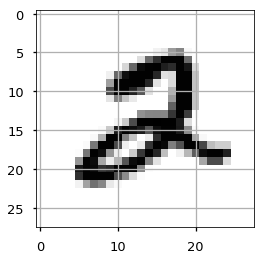

In [12]:
plot_mnist_image(5, train_imgs, train_labels)

## A note on the curse of dimensionality

Define a similarity measure. For instance, the [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity), that is 1 if vectors are parallel (most similar), and zero if they are perpendicular (lack of correlation).

In [13]:
from scipy import spatial

def cosine_similarity(img1, img2):
    # reshape input matrices as vectors
    img1_ = img1.reshape((28*28,))
    img2_ = img2.reshape((28*28,))
    # normalize input vectors
    norm1 = np.sqrt(np.sum(img1_*img1_))
    norm2 = np.sqrt(np.sum(img2_*img2_))
    img1_ = img1_ / norm1
    img2_ = img2_ / norm2
    sim = 1 - spatial.distance.cosine(img1_, img2_)    
    return sim

Check the similarity among two random images, and plot them. Does it make sense?

In [14]:
cosine_similarity(train_imgs[0], train_imgs[1])

0.5521001886778967

The image below should show the number 5


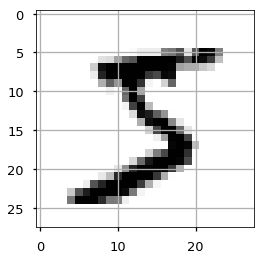

In [15]:
plot_mnist_image(0, train_imgs, train_labels)

The image below should show the number 0


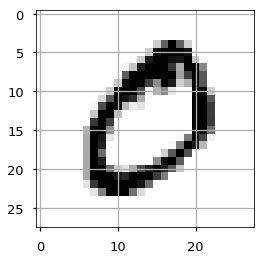

In [16]:
plot_mnist_image(1, train_imgs, train_labels)

What about the similarity among images of numbers 5?

In [18]:
train_imgs.shape

(60000, 28, 28)

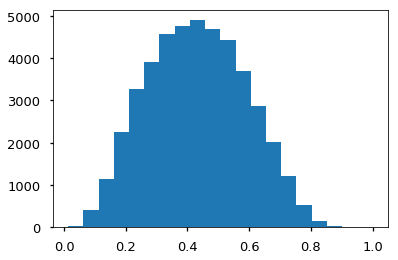

In [24]:
labels5 = train_labels == 5
imgs5 = train_imgs[labels5]
index = np.random.randint(0, imgs5.shape[0], size=300)
distances55=[]
for i,img1 in enumerate(imgs5[index]):
    for j, img2 in enumerate(imgs5[index]):
        if j > i:
            distances55.append(cosine_similarity(img1, img2))
            
plt.hist(np.array(distances55), bins = 20)
plt.show()

Try the similarity between 5 and 4, or 5 and 8, for instance

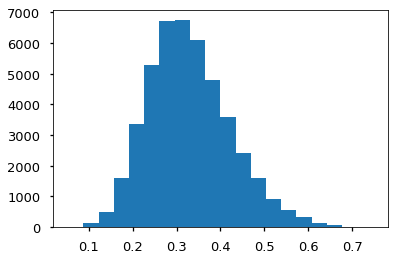

In [26]:
labels1 = train_labels == 1
imgs1 = train_imgs[labels1]
index1 = np.random.randint(0, imgs1.shape[0], size=300)
distances51=[]
for i,img1 in enumerate(imgs5[index]):
    for j, img2 in enumerate(imgs1[index1]):
        if j > i:
            distances51.append(cosine_similarity(img1, img2))
            
plt.hist(np.array(distances51), bins = 20)
plt.show()

Vemos que los 5's  y los  1's se parecen entre si como los 5's a si mismos. Y esto en imagenes minusculas (28*28)! El concepto de distancia no es util en dimensiones altas.



<div class="alert alert-success">
As the dimension of our input increases, everything starts looking the same. Distances in high dimensions cannot be used! This is a consequence of the curse of dimensionality.
</div>

We will design a network that will be able to recognize the number shown at the image (for all the images in the test set)

## Data transform

We need to change the shape of the data, so it can be fed to the network more easily

In [ ]:
# get the min, max, meand and std of training images


All the images are 28x28 matrices, with values between 0 and 255. Let's normalize the images, to avoid problems in the numerical computations using large numbers.

We will convert the matrix to a vector with 28x28 components, stacking columns on top of each other. This will make the design of the network.
* Alternatively, we could add a `Flatten(input_shape=(28,28))` layer to the model

In [27]:
# normalize image's values to the maximum
# normalizamos por el maximo (valen otros)
train_imgs_t = train_imgs / train_imgs.max()
test_imgs_t = test_imgs / test_imgs.max()

Because we want to assign a *category* to each image, we need to transform the output to categorical format

In [28]:
from keras.utils import to_categorical

Initially, our target data is just a set of numbers

In [30]:
train_labels[0]

5

We are going to transform it to **1-HOT encoding format**

In [32]:
train_labels_t = to_categorical(train_labels)


In [33]:
train_labels_t[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

We have to repeat the same process with the test data

In [34]:
test_labels_t = to_categorical(test_labels)

## Let's build the model

In [35]:
from keras import models
from keras import layers

In [36]:
def build_model():
    m = models.Sequential()
    m.add(layers.Flatten(input_shape = (28,28))) # esta capa solo pasa a una dimension, no añade parametros
    m.add(layers.Dense(512, activation='relu')) # esta capa comprime la informacion
    m.add(layers.Dense(256, activation='relu'))
    m.add(layers.Dense(10, activation='softmax'))
    return m


In [37]:
m = build_model()

In [38]:
from keras import optimizers
from keras import metrics
from keras import losses

In [ ]:
m.compile(
optimizer = optimizers.)

Here we will make some decisions about how to train our model.

The **objective function**, called also the **loss function** in Machine Learning, will be *categorical crossentropy*. This is because we are trying to predict discrete classes. If we choose a different function, the solution will be different (take a look at [Keras available losses](https://keras.io/losses/)). This is the function that will tell us when we have found the *solution*. Different functions will point to different *solutions*. The categorical crossentropy for a single observation (exmaple in train, for instance) is defined as:

$$-\sum_{{\rm category} = 1}^M y_{\rm category} \log(\hat{y}_{\rm category}).$$

Have a look at this [cheatsheet](https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html).

The **optimizer** is the method that we will use to find the minimum of the **loss function**. In general, we will not find the global minimum of the loss function, but a minimum that is good enough. *RMSProp* is one the variants of gradient descent. But there are many more [availbale in Keras](https://keras.io/optimizers/). We will deep dive into the optimization problem later in this course. 
 
These two settings will define the family of solutions we will find during the training process.

The other parameter, the **metrics**, is only for information purposes. In each step of the training (called **epoch**), Keras will report the value of the metrics. But whether we choose one metric or another will not influence the training process. It is only for reporting how the training is going. That information will be useful for the validation of the model, that is, for the **hyperparameters tuning**.


In [ ]:
from keras import optimizers
from keras import losses
from keras import metrics

In [ ]:
m = build_model()

In [ ]:
# compile the model


In [ ]:
# get the summary
m.summary()

Now let's fit the neural network. We will keep the results in a *history* object to plot some parameters after the training, and use that information for improving our model (changing layers, activation functions, etc). This process is called **hyperparameters tuning** or hypeparameters search.

Here we need to set two parameters: the number of **epochs** and the **batch size**.

In previous cells, I have said that the training process is an optimization problem: we try to find the minimum.

That's actually not entirely true. In practice, we don't keep searching for a minimum. Instead, we train for a preset number of epochs. Then we analyze the output using the validation set. If we detect overfit, then we reduce the number of epochs. If we don't detect it, then maybe we can keep going for some more epochs to find a better model. The number of epochs is another hyperparameter. In general, we should stop the training as early as possible. Any further epoch can make our model overfit, and therefore generalize poorly.

The batch size is another hyperparameter. The network is not updated item by item, vector by vector. We can actually calculate the weights for a batch of several items, forming a matrix or a tensor. The batch size will affect the granularity of the calculations and the performance. A larger batch size will probably result in a slightly worse accuracy, but in a better performance. As long as the batch size is not so huge that it cannot be kept in memory. Because we are running on a GPU, it is a good idea to use a power of 2 for the batch size. It will probably make a better use of the GPU. But again, the effect of the batch size must be tested using the validation set, and adjusted until we find a good value for that parameter.

An epoch is a full pass over the training dataset. At the end of each epoch, Keras will calculate the value of the metrics for the training set, and the loss function and metrics for the validation set. The loss and metrics of the validation set are useful for the hyperparameters tuning process.



In [ ]:
# train!
h = <fill in>

In [ ]:
plot_metric(h, 'loss')

In [ ]:
plot_metric(h, 'categorical_accuracy')


Now let's check how well the model works with the test dataset. Remember that we don't have used it at all during the training and tuning of the model.

## Analyze the classification performance

For this, we will use the model's `evaluation` method. 

In [ ]:
loss, acc = m.evaluate(<test images>, <test labels>)

In [ ]:
loss, acc

Let's see how well it predicts some random items from the test set.

In [ ]:
# plot a random image 


The prediction is a 10-element vector (*1-HOT encoded vector*), with (something like) the probability of each class. The location of the max is giving us the predicted class.

In [ ]:
# get the prediction of that same image. This process is what it's called **inference**.


In [ ]:
np.argmax(<your prediciton>)

## Exercises

**EXERCISE 1**: Change the [activation function](https://keras.io/activations/) in the model. How does it affect accuracy? What happens if you use linear activation function? What happens if we use the $\tanh$ function? Does it affect to overfitting?

 
Here we see that the accuracy keeps increasing over epochs. An overfitted model would produce a decrease of the validation accuracy at some point. This means that we have found an optimal model. The validation loss is stuck at a minimum, but the accuracy is not affected by the extra epochs.

_**EXERCISE 2**_: How is the model accuracy affected if we start over and fit for 40 epochs? And for 4? And for 400?

_**EXERCISE 4**_: What is the most simple model that you can get that achieves a similar validation performance (accuracy)? (Note that the loss values might not be comparable if we use regularization techniques, change the network architecture, etc.)

_**EXERCISE 5**_: Can you find a test item that is predicted wrongly? How many images are predicted wrongly? Can you find all the items that are wrongly classified? 

_**EXERCISE 6**_: Some digits are more difficult to recognize than others. Because we know the test labels, we can find out how many times the corresponding test images are misclassified. Could you find what are the top 3 test labels that are more often misclassified?